In [1]:
import datetime
import lakeapi
import lakeapi.orderbook
import plotly
import plotly.express as px
import pandas as pd

# remove the following row if you are running the notebook on your computer and want to use full paid market data
lakeapi.use_sample_data(anonymous_access = True)

# Adatok betöltése
start_date = datetime.datetime(2024, 4, 1)
end_date = datetime.datetime(2024, 4, 2)

diffs = lakeapi.load_data(
    table="book_delta_v2",
    start=start_date,
    end=end_date,
    symbols=["BTC-USDT"],
    exchanges=['BINANCE'],
)

# Adatok ellenőrzése betöltés után
print(f"Betöltött adatok száma: {len(diffs)}")
print(f"Adatok időtartománya: {diffs['origin_time'].min()} - {diffs['origin_time'].max()}")

# Szűrés a megadott időtartományra
filtered_diffs = diffs[(diffs['origin_time'] >= start_date) & (diffs['origin_time'] <= end_date)]

# Szűrt adatok ellenőrzése
print(f"\nSzűrt adatok száma: {len(filtered_diffs)}")
print(f"Szűrt adatok időtartománya: {filtered_diffs['origin_time'].min()} - {filtered_diffs['origin_time'].max()}")

# Kiszűrt sorok számának ellenőrzése
filtered_out = len(diffs) - len(filtered_diffs)
print(f"Kiszűrt sorok száma: {filtered_out} ({filtered_out/len(diffs)*100:.2f}%)")

# Az első 5 sor megjelenítése
print("\nAz első 5 sor a szűrt adatokból:")
filtered_diffs.head(5)

/home/andras/miniconda3/envs/rapids-25.02/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Betöltött adatok száma: 21513277
Adatok időtartománya: 1970-01-01 00:00:00 - 2024-04-01 23:59:59.898000128

Szűrt adatok száma: 21503277
Szűrt adatok időtartománya: 2024-04-01 00:00:00.066999808 - 2024-04-01 23:59:59.898000128
Kiszűrt sorok száma: 10000 (0.05%)

Az első 5 sor a szűrt adatokból:


,origin_time,received_time,sequence_number,side_is_bid,price,size,exchange,symbol
0,2024-04-01 00:00:00.066999808,2024-04-01 00:00:00.097469440,45220867676,True,71280.00,0.15663,BINANCE,BTC-USDT
1,2024-04-01 00:00:00.066999808,2024-04-01 00:00:00.097469440,45220867676,True,71273.68,0.00000,BINANCE,BTC-USDT
2,2024-04-01 00:00:00.066999808,2024-04-01 00:00:00.097469440,45220867676,True,71273.41,0.00140,BINANCE,BTC-USDT
3,2024-04-01 00:00:00.066999808,2024-04-01 00:00:00.097469440,45220867676,True,71272.89,0.00000,BINANCE,BTC-USDT
4,2024-04-01 00:00:00.066999808,2024-04-01 00:00:00.097469440,45220867676,True,71267.36,0.28436,BINANCE,BTC-USDT


In [2]:
%load_ext cudf.pandas

In [3]:
import pandas as pd

# Feltételezzük, hogy a 'filtered_diffs' egy Pandas DataFrame, amely az order book delta adatokat tartalmazza
# Átalakítjuk cuDF DataFrame-be a GPU-gyorsított feldolgozáshoz
gdf = filtered_diffs

# Kerekítsük a received_time-et egész másodpercekre (cuDF-ben a "S" nagybetűs formátumot kell használni)
gdf['second'] = gdf['received_time'].dt.floor('S')

# Szétválasztjuk a vételi (bid) és eladási (ask) eseményeket a 'side_is_bid' alapján
bids = gdf[gdf['side_is_bid'] == True]
asks = gdf[gdf['side_is_bid'] == False]

# Minden másodpercben meghatározzuk a best bid-et (a legmagasabb vételi árat)
best_bid = bids.groupby('second').agg({'price': 'max'}).reset_index()

# Ugyanez a best ask esetében (a legalacsonyabb eladási ár)
best_ask = asks.groupby('second').agg({'price': 'min'}).reset_index()

# A best bid-hez tartozó összesített volumen kiszámítása:
# Először merge-eljük a bids DataFrame-et a best_bid-el a "second" oszlop alapján
bids = bids.merge(best_bid, on='second', suffixes=('', '_best'))
# Csak azokat az eseményeket vesszük figyelembe, ahol a price megegyezik a best bid értékkel,
# majd csoportosítjuk "second" szerint, és összegyűjtjük az összeadott 'size'-okat
bids_best = bids[bids['price'] == bids['price_best']].groupby('second').agg({'size': 'sum'}).reset_index()

# Ugyanez a best ask-re:
asks = asks.merge(best_ask, on='second', suffixes=('', '_best'))
asks_best = asks[asks['price'] == asks['price_best']].groupby('second').agg({'size': 'sum'}).reset_index()

# Egyesítsük az eredményeket, hogy másodpercenként teljes order book snapshotot kapjunk:
# Először merge-eljük a best bid és best ask adatokat
orderbook = best_bid.merge(best_ask, on='second', suffixes=('_bid', '_ask'))
# Ezután egyesítjük a best bid-hez és best ask-hez tartozó volumenelemeket is
orderbook = orderbook.merge(bids_best, on='second').merge(asks_best, on='second', suffixes=('_bid_size', '_ask_size'))

# Átnevezzük az oszlopokat az átláthatóság kedvéért:
orderbook = orderbook.rename(columns={
    'price_bid': 'best_bid',
    'price_ask': 'best_ask',
    'size_bid_size': 'bid_size',
    'size_ask_size': 'ask_size'
})

# Számoljuk ki a Volume-Adjusted Mid-Price (VAMP)-ot a következő képlettel:
# VAMP = ((best_bid * ask_size) + (best_ask * bid_size)) / (bid_size + ask_size)
orderbook['VAMP'] = (orderbook['best_bid'] * orderbook['ask_size'] + orderbook['best_ask'] * orderbook['bid_size']) / (orderbook['bid_size'] + orderbook['ask_size'])

# Az orderbook DataFrame most tartalmazza az aggregált snapshotot minden másodpercre,
# beleértve a best bid, best ask, bid_size, ask_size és a számított VAMP értékeket.
print(orderbook.head())


/tmp/ipykernel_932/2680747576.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  gdf['second'] = gdf['received_time'].dt.floor('S')
/tmp/ipykernel_932/2680747576.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['second'] = gdf['received_time'].dt.floor('S')


               second  best_bid  best_ask  bid_size  ask_size          VAMP
0 2024-04-01 00:00:00  71280.00  71280.01   0.15663   9.22349  71280.000167
1 2024-04-01 00:00:01  71288.22  71280.01  30.10241  48.22940  71285.064950
2 2024-04-01 00:00:02  71288.22  71269.94   0.00000   5.87252  71288.220000
3 2024-04-01 00:00:03  71269.93  71250.01   0.00000  20.30925  71269.930000
4 2024-04-01 00:00:04  71250.00  71250.01   1.13363  68.54276  71250.000163


In [5]:
import pandas as pd

# Feltételezzük, hogy a 'filtered_diffs' egy Pandas DataFrame, amely az order book delta adatokat tartalmazza.
# (%load_ext cudf.pandas aktiválva van, így GPU gyorsított Pandas műveletek futnak)

gdf = filtered_diffs.copy()

# Kerekítsük a received_time-et egész másodpercekre.
gdf['second'] = gdf['received_time'].dt.floor('S')

### 1. Mid-price (top1 bid és ask számtani átlaga)
# Szétválasztjuk a vételi (bid) és eladási (ask) eseményeket
bids_top1 = gdf[gdf['side_is_bid'] == True].groupby('second').agg({'price': 'max'}).reset_index()
asks_top1 = gdf[gdf['side_is_bid'] == False].groupby('second').agg({'price': 'min'}).reset_index()

# Egyesítjük a top1 bid és ask adatokat
orderbook_top1 = bids_top1.merge(asks_top1, on='second', suffixes=('_bid', '_ask'))
# Számoljuk ki a mid_price-t (csak a legjobb vételi és eladási ár számtani átlaga)
orderbook_top1['mid_price'] = (orderbook_top1['price_bid'] + orderbook_top1['price_ask']) / 2

### 2. VAMP (a top5 bid és ask alapján)
# Szűrjük a vételi és eladási eseményeket
bids = gdf[gdf['side_is_bid'] == True].copy()
asks = gdf[gdf['side_is_bid'] == False].copy()

# Rendezés: 
# Bids esetében: "second" szerint növekvő, majd "price" szerint csökkenő sorrend
bids = bids.sort_values(by=['second', 'price'], ascending=[True, False])
# Asks esetében: "second" szerint növekvő, majd "price" szerint növekvő sorrend
asks = asks.sort_values(by=['second', 'price'], ascending=[True, True])

# Számoljuk ki a csoporton belüli sorszámot (cumcount) minden "second" csoportban
bids['rank'] = bids.groupby('second').cumcount()
asks['rank'] = asks.groupby('second').cumcount()

# Csak a top5 sort választjuk ki az egyes csoportokból
bids_top5 = bids[bids['rank'] < 3].copy()
asks_top5 = asks[asks['rank'] < 3].copy()

# Számoljuk ki a "price * size" értékeket
bids_top5['price_times_size'] = bids_top5['price'] * bids_top5['size']
asks_top5['price_times_size'] = asks_top5['price'] * asks_top5['size']

# Aggregálás másodpercenként (vectorized)
bids_agg = bids_top5.groupby('second').agg({
    'price_times_size': 'sum',
    'size': 'sum'
}).rename(columns={'price_times_size': 'weighted_bid_sum', 'size': 'bid_volume'}).reset_index()
bids_agg['weighted_bid'] = bids_agg['weighted_bid_sum'] / bids_agg['bid_volume']

asks_agg = asks_top5.groupby('second').agg({
    'price_times_size': 'sum',
    'size': 'sum'
}).rename(columns={'price_times_size': 'weighted_ask_sum', 'size': 'ask_volume'}).reset_index()
asks_agg['weighted_ask'] = asks_agg['weighted_ask_sum'] / asks_agg['ask_volume']

# Egyesítsük az aggregált vételi és eladási adatokat
orderbook_top5 = pd.merge(bids_agg[['second', 'weighted_bid', 'bid_volume']],
                          asks_agg[['second', 'weighted_ask', 'ask_volume']],
                          on='second', how='inner')

# Számoljuk ki a VAMP-ot a top5 súlyozott átlagok alapján:
# VAMP = ((weighted_bid * ask_volume) + (weighted_ask * bid_volume)) / (bid_volume + ask_volume)
orderbook_top5['VAMP'] = (orderbook_top5['weighted_bid'] * orderbook_top5['ask_volume'] +
                          orderbook_top5['weighted_ask'] * orderbook_top5['bid_volume']) / (orderbook_top5['bid_volume'] + orderbook_top5['ask_volume'])

### 3. Egyesítsük a top1 mid_price-t és a top5 VAMP-ot
orderbook_combined = pd.merge(orderbook_top1[['second', 'mid_price']],
                              orderbook_top5[['second', 'VAMP']],
                              on='second', how='inner')

print(orderbook_combined.head())


/tmp/ipykernel_932/2483360120.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  gdf['second'] = gdf['received_time'].dt.floor('S')


               second  mid_price          VAMP
0 2024-04-01 00:00:00  71280.005  71279.945982
1 2024-04-01 00:00:01  71284.115  71284.661130
2 2024-04-01 00:00:02  71279.080           NaN
3 2024-04-01 00:00:03  71259.970           NaN
4 2024-04-01 00:00:04  71250.005  71250.000219


In [16]:
import numpy as np

target_second = np.datetime64("2024-04-01T00:00:02")
filtered_df = gdf[gdf['second'] == target_second]
print(filtered_df.head(5))





                 origin_time                 received_time  sequence_number  \
1103 2024-04-01 00:00:01.768 2024-04-01 00:00:02.583081216      45220869798   
1104 2024-04-01 00:00:01.768 2024-04-01 00:00:02.583081216      45220869798   
1105 2024-04-01 00:00:01.768 2024-04-01 00:00:02.583081216      45220869798   
1106 2024-04-01 00:00:01.768 2024-04-01 00:00:02.583081216      45220869798   
1107 2024-04-01 00:00:01.768 2024-04-01 00:00:02.583081216      45220869798   

      side_is_bid     price  size exchange    symbol              second  
1103         True  71288.22   0.0  BINANCE  BTC-USDT 2024-04-01 00:00:02  
1104         True  71288.15   0.0  BINANCE  BTC-USDT 2024-04-01 00:00:02  
1105         True  71288.00   0.0  BINANCE  BTC-USDT 2024-04-01 00:00:02  
1106         True  71286.87   0.0  BINANCE  BTC-USDT 2024-04-01 00:00:02  
1107         True  71286.86   0.0  BINANCE  BTC-USDT 2024-04-01 00:00:02  


90%-os abszolút különbség: 2.4923332811275083


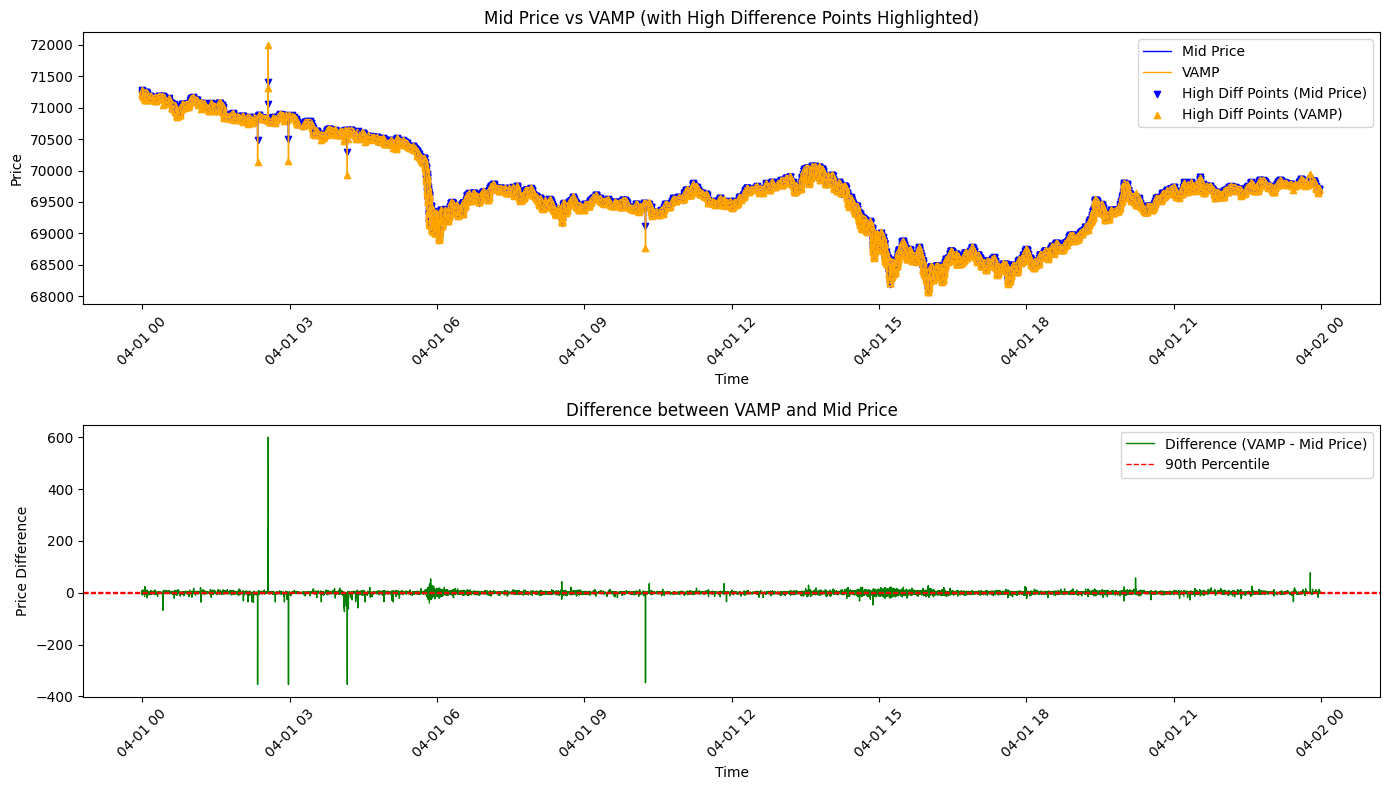

In [13]:
import matplotlib.pyplot as plt
import cudf

# Tegyük fel, hogy már rendelkezésedre áll az orderbook nevű cuDF DataFrame, 
# amely tartalmazza a 'second', 'VAMP' és 'mid_price' oszlopokat.

# Konvertáljuk cuDF DataFrame-et Pandas DataFrame-re az ábrázoláshoz
orderbook_pd = orderbook.to_pandas()

# Rendezés idő szerint
orderbook_pd = orderbook_pd.sort_values('second')

# Számoljuk ki a különbséget a VAMP és mid_price között
orderbook_pd['diff'] = orderbook_pd['VAMP'] - orderbook_pd['mid_price']

# Határozzuk meg a 90%-os kvantilis abszolút különbségét
threshold = orderbook_pd['diff'].abs().quantile(0.90)
print("90%-os abszolút különbség:", threshold)

# Szűrjük azokat az időpontokat, ahol a különbség abszolút értéke nagyobb vagy egyenlő a threshold értéknél
high_diff = orderbook_pd[orderbook_pd['diff'].abs() >= threshold]

# Ábrázolás
plt.figure(figsize=(14, 8))

# Első subplot: a VAMP és mid_price alakulása
plt.subplot(2, 1, 1)
plt.plot(orderbook_pd['second'], orderbook_pd['mid_price'], label='Mid Price', color='blue', linewidth=1)
plt.plot(orderbook_pd['second'], orderbook_pd['VAMP'], label='VAMP', color='orange', linewidth=1)
# Kiemeljük a high_diff pontokat – ezeknél a különbségnél nagyobb mint a threshold
plt.scatter(high_diff['second'], high_diff['mid_price'], color='blue', marker='v', s=20, label='High Diff Points (Mid Price)')
plt.scatter(high_diff['second'], high_diff['VAMP'], color='orange', marker='^', s=20, label='High Diff Points (VAMP)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Mid Price vs VAMP (with High Difference Points Highlighted)')
plt.legend()
plt.xticks(rotation=45)

# Második subplot: a különbség (VAMP - Mid Price)
plt.subplot(2, 1, 2)
plt.plot(orderbook_pd['second'], orderbook_pd['diff'], color='green', linewidth=1, label='Difference (VAMP - Mid Price)')
# Ábrázoljuk a threshold vonalat
plt.axhline(threshold, color='red', linestyle='--', linewidth=1, label='90th Percentile')
plt.axhline(-threshold, color='red', linestyle='--', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Price Difference')
plt.title('Difference between VAMP and Mid Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [14]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import os

def create_interactive_vamp_midprice_plot(orderbook, output_file='vamp_midprice_comparison.html'):
    """
    Create an interactive plot comparing VAMP and mid_price with zooming capabilities
    
    Args:
        orderbook: cuDF or pandas DataFrame with 'second', 'VAMP', and 'mid_price' columns
        output_file: Path to save the HTML output file
    """
    # Ensure we're working with pandas DataFrame
    if hasattr(orderbook, 'to_pandas'):
        orderbook_pd = orderbook.to_pandas()
    else:
        orderbook_pd = orderbook.copy()
    
    # Rendezés idő szerint
    orderbook_pd = orderbook_pd.sort_values('second')
    
    # Számoljuk ki a különbséget a VAMP és mid_price között
    orderbook_pd['diff'] = orderbook_pd['VAMP'] - orderbook_pd['mid_price']
    orderbook_pd['diff_percent'] = (orderbook_pd['diff'] / orderbook_pd['mid_price']) * 100
    
    # Határozzuk meg a 90%-os kvantilis abszolút különbségét
    threshold = orderbook_pd['diff'].abs().quantile(0.90)
    threshold_percent = orderbook_pd['diff_percent'].abs().quantile(0.90)
    
    print(f"90%-os abszolút különbség: {threshold:.6f}")
    print(f"90%-os relatív különbség: {threshold_percent:.6f}%")
    
    # Szűrjük azokat az időpontokat, ahol a különbség abszolút értéke nagyobb vagy egyenlő a threshold értéknél
    high_diff = orderbook_pd[orderbook_pd['diff'].abs() >= threshold]
    
    # Készítsünk interaktív ábrát Plotly-val
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=(
            'Mid Price vs VAMP (with High Difference Points Highlighted)',
            'Absolute Difference (VAMP - Mid Price)',
            'Percentage Difference (VAMP - Mid Price)'
        ),
        row_heights=[0.5, 0.25, 0.25]
    )
    
    # Első subplot: a VAMP és mid_price alakulása
    fig.add_trace(
        go.Scatter(
            x=orderbook_pd['second'], 
            y=orderbook_pd['mid_price'],
            mode='lines',
            name='Mid Price',
            line=dict(color='blue', width=1)
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=orderbook_pd['second'], 
            y=orderbook_pd['VAMP'],
            mode='lines',
            name='VAMP',
            line=dict(color='orange', width=1)
        ),
        row=1, col=1
    )
    
    # Kiemeljük a high_diff pontokat
    fig.add_trace(
        go.Scatter(
            x=high_diff['second'], 
            y=high_diff['mid_price'],
            mode='markers',
            name='High Diff Points (Mid Price)',
            marker=dict(color='blue', symbol='triangle-down', size=8)
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=high_diff['second'], 
            y=high_diff['VAMP'],
            mode='markers',
            name='High Diff Points (VAMP)',
            marker=dict(color='orange', symbol='triangle-up', size=8)
        ),
        row=1, col=1
    )
    
    # Második subplot: az abszolút különbség (VAMP - Mid Price)
    fig.add_trace(
        go.Scatter(
            x=orderbook_pd['second'], 
            y=orderbook_pd['diff'],
            mode='lines',
            name='Difference (VAMP - Mid Price)',
            line=dict(color='green', width=1)
        ),
        row=2, col=1
    )
    
    # Ábrázoljuk a threshold vonalakat
    fig.add_trace(
        go.Scatter(
            x=[orderbook_pd['second'].min(), orderbook_pd['second'].max()],
            y=[threshold, threshold],
            mode='lines',
            name='90th Percentile',
            line=dict(color='red', width=1, dash='dash')
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=[orderbook_pd['second'].min(), orderbook_pd['second'].max()],
            y=[-threshold, -threshold],
            mode='lines',
            name='-90th Percentile',
            line=dict(color='red', width=1, dash='dash'),
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Harmadik subplot: a százalékos különbség
    fig.add_trace(
        go.Scatter(
            x=orderbook_pd['second'], 
            y=orderbook_pd['diff_percent'],
            mode='lines',
            name='Percentage Difference',
            line=dict(color='purple', width=1)
        ),
        row=3, col=1
    )
    
    # Ábrázoljuk a százalékos threshold vonalakat
    fig.add_trace(
        go.Scatter(
            x=[orderbook_pd['second'].min(), orderbook_pd['second'].max()],
            y=[threshold_percent, threshold_percent],
            mode='lines',
            name='90th Percentile (%)',
            line=dict(color='red', width=1, dash='dash')
        ),
        row=3, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=[orderbook_pd['second'].min(), orderbook_pd['second'].max()],
            y=[-threshold_percent, -threshold_percent],
            mode='lines',
            name='-90th Percentile (%)',
            line=dict(color='red', width=1, dash='dash'),
            showlegend=False
        ),
        row=3, col=1
    )
    
    # Formázzuk az ábrát
    fig.update_layout(
        title='VAMP vs Mid Price Comparison (Interactive)',
        height=900,
        width=1200,
        hovermode='x unified',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    # X tengely formázása
    fig.update_xaxes(
        title_text='Time',
        row=3, col=1
    )
    
    # Y tengely formázása
    fig.update_yaxes(
        title_text='Price',
        row=1, col=1
    )
    
    fig.update_yaxes(
        title_text='Absolute Difference',
        row=2, col=1
    )
    
    fig.update_yaxes(
        title_text='Percentage Difference (%)',
        row=3, col=1
    )
    
    # Hozzáadunk egy range slider-t
    fig.update_layout(
        xaxis=dict(
            rangeslider=dict(visible=True),
            type='date'
        )
    )
    
    # Hozzáadunk néhány gombot a különböző nagyítási szintekhez
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                buttons=list([
                    dict(
                        args=[{"yaxis.autorange": True, "yaxis2.autorange": True, "yaxis3.autorange": True}],
                        label="Reset Y Axis",
                        method="relayout"
                    ),
                    dict(
                        args=[{"xaxis.autorange": True}],
                        label="Reset X Axis",
                        method="relayout"
                    ),
                    dict(
                        args=[{"yaxis.autorange": True, "yaxis2.autorange": True, "yaxis3.autorange": True, "xaxis.autorange": True}],
                        label="Reset All",
                        method="relayout"
                    ),
                ]),
                pad={"r": 10, "t": 10},
                showactive=False,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )
    
    # Mentés HTML fájlba
    fig.write_html(output_file)
    print(f"Interactive plot saved to {os.path.abspath(output_file)}")
    
    return fig


orderbook_pd = orderbook.to_pandas()
fig = create_interactive_vamp_midprice_plot(orderbook_pd)

90%-os abszolút különbség: 2.492333
90%-os relatív különbség: 0.003588%
Interactive plot saved to /home/andras/vamp_midprice_comparison.html
